<h1>Applied Data Science Capstone with IBM</h1>

<h2>Plan a route for a mobile restaurant, Canada</h2>

<h3>By: Yves Godbout</h3>

<h3>Introduction</h3>


Laval is a charming city very close to Montreal, in Canada. It has benefited from significant real estate and commercial development due to its proximity to the big city. It is good to live there since Laval does not experience the same traffic challenges and infrastructure problems as Montreal.
There are major shopping centers and enviable commercial avenues. Now suppose we have a mobile restaurant that mainly serves beaver tails (which is a delicious Canadian pastry). The mobile restaurant market is not yet very developed in Laval, (while in Montreal, it is saturated) so we want to take the opportunity to take our place.
But we must choose one or more strategic places where it would be most appropriate to install our vehicle. So let's explore Laval's data via Foursquare.


<h3>Business Problem</h3>

All populous places are generally well surrounded by restaurants. Shopping centers already have food courts and competition is very important. Travel can be laborious. I would like to maximize my stops to reach the maximum number of customers. Currently, we do not know where we are focusing and we do not have an overview of the shops in the city.

It’s not about running away from other restaurants. Beaver tails can be a great addition to a tedious meal. So we would like to stick close to certain restaurants, but not those that would compete with us (such as cafes or dessert places). Likewise, we are not looking to stick close to a health center (gym).

In short, we are trying to reach as many people as possible. To do this, visibility must be excellent. In addition, children will love these pastries.

<h3>Target audience of this project</h3>

Any mobile restaurant entrepreneur looking for a solution in a city he knows little about.


<h3>Data Overview and requirement</h3>

For this assignment, I will be utilizing the Foursquare API to pull the following location data on commerces in Laval.

In this case, we will need these values :

•	Venue Name
•	Venue ID
•	Venue Location
•	Venue Category
•	Count of Likes


<h3>Methodology and data acquisition approach</h3>

<h4>To obtain the necessary data, here are the steps that will be taken:</h4>
    
    •	Get geolocator latitude and longitude coordinates for Laval, Canada ;
    •	Use Foursquare API to get a list of all venues in Laval ;
    •	Venue data, particularly data related to shopping malls. We will use this data to perform clustering on the neighbourhoods, venue.name, venue.id, venue.categories, venue.location.lat, venue.location.lng ;
    •	Pull menu and count of likes for each venue ;
    •	I'm going to mix all of this and probably filter out a few businesses and group together a few to make it easier to read.
    
I will take the data collected and create a dynamic of k-means which groups businesses in 3 clusters. That way, I should be able to illustrate my results in a table and under a map and so the results will be easier to read and hopefully the solution more obvious.


<h3>Data preparation</h3>

We will import our necessary packages and start pulling our data for data prep and usage.

In [1]:
pip install geopy

     |████████████████████████████████| 112kB 5.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade bs4

     |████████████████████████████████| 112kB 20.2MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geocoder

     |████████████████████████████████| 102kB 7.5MB/s ta 0:00:01
     |████████████████████████████████| 829kB 17.1MB/s eta 0:00:01
     |████████████████████████████████| 81kB 17.1MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


<h3>Import libraries</h3>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


<h3>Scrap data from Wikipedia page into a DataFrame</h3>

In [2]:
# send the GET request
data = requests.get("https://en.wikipedia.org/wiki/Laval,_Quebec").text

In [3]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [4]:
# create a list to store neighborhood data
neighborhoodList = []

In [5]:
# append the data into the list
for row in soup.find_all("div", class_="div-col columns column-width")[0].findAll("li"):
    neighborhoodList.append(row.text)

In [6]:
# create a new DataFrame from the list
laval_df = pd.DataFrame({"Neighborhood": neighborhoodList})

laval_df.head(16)

,Neighborhood
0,Auteuil
1,Chomedey
2,Duvernay
3,Fabreville
4,Îles-Laval
5,Laval-des-Rapides
6,Laval-Ouest
7,Laval-sur-le-Lac
8,Pont-Viau
9,Sainte-Dorothée


In [7]:
# print the number of rows of the dataframe
laval_df.shape

(14, 1)

<h2>Get the geographical coordinates</h2>

In [8]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Laval, Canada'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [9]:
# call the function to get the coordinates, store in a new list using list comprehension
laval_coord = [ get_latlng(neighborhood) for neighborhood in laval_df["Neighborhood"].tolist() ]

In [10]:
laval_coord

[[45.635200000000054, -73.76450999999997],
 [45.535000000000025, -73.74787999999995],
 [45.59358000000003, -73.66391999999996],
 [45.568170000000066, -73.83966999999996],
 [45.520140000000026, -73.85273999999998],
 [45.55937000000006, -73.71255999999994],
 [45.545480000000055, -73.87373999999994],
 [45.52531000000005, -73.88222999999994],
 [45.57869000000005, -73.68100999999996],
 [45.527300000000025, -73.81275999999997],
 [45.601620000000025, -73.78939999999994],
 [45.66769000000005, -73.57322999999997],
 [45.611140000000034, -73.64502999999996],
 [45.60056000000003, -73.72585999999995]]

In [11]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
td_coord = pd.DataFrame(laval_coord, columns=['Latitude', 'Longitude'])

In [12]:
# merge the coordinates into the original dataframe
laval_df['Latitude'] = td_coord['Latitude']
laval_df['Longitude'] = td_coord['Longitude']

In [13]:
# check the neighborhoods and the coordinates
print(laval_df.shape)
laval_df

(14, 3)


,Neighborhood,Latitude,Longitude
0,Auteuil,45.63520,-73.76451
1,Chomedey,45.53500,-73.74788
2,Duvernay,45.59358,-73.66392
3,Fabreville,45.56817,-73.83967
4,Îles-Laval,45.52014,-73.85274
5,Laval-des-Rapides,45.55937,-73.71256
6,Laval-Ouest,45.54548,-73.87374
7,Laval-sur-le-Lac,45.52531,-73.88223
8,Pont-Viau,45.57869,-73.68101
9,Sainte-Dorothée,45.52730,-73.81276


<h3>Finding the geographic data for Laval</h3>

In [14]:
address = 'Laval, Quebec'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Here are the geographic coordinates for Laval : {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


Here are the geographic coordinates for Laval : 45.60558895, -73.73441730569056.


<h3>Foursquare extraction</h3>

In [15]:
CLIENT_ID = '5DQZWFFGZHF12MOVUE4PVZKPKZCMAG5YRW1ORNJA3QMZR325' # your Foursquare ID
CLIENT_SECRET = 'RNNWLMBDQTBMZOHNRR3U2G1HCMA2SBKHNF1IQAAU2XTCMXKE' # your Foursquare Secret
VERSION = '20191017' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5DQZWFFGZHF12MOVUE4PVZKPKZCMAG5YRW1ORNJA3QMZR325
CLIENT_SECRET:RNNWLMBDQTBMZOHNRR3U2G1HCMA2SBKHNF1IQAAU2XTCMXKE


<h3>Since it is a not so big city, I put the radius to 5000.</h3>

In [16]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius

# create URL
laval_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
laval_url

'https://api.foursquare.com/v2/venues/explore?&client_id=5DQZWFFGZHF12MOVUE4PVZKPKZCMAG5YRW1ORNJA3QMZR325&client_secret=RNNWLMBDQTBMZOHNRR3U2G1HCMA2SBKHNF1IQAAU2XTCMXKE&v=20191017&ll=45.60558895,-73.73441730569056&radius=5000&limit=100'

In [17]:
results = requests.get(laval_url).json()
results

{'meta': {'code': 200, 'requestId': '5e418c7cc546f3001c74f695'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Laval',
  'headerFullLocation': 'Laval',
  'headerLocationGranularity': 'city',
  'totalResults': 191,
  'suggestedBounds': {'ne': {'lat': 45.65058899500004,
    'lng': -73.67021428557736},
   'sw': {'lat': 45.56058890499995, 'lng': -73.79862032580375}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4dd687eb1f6ee146830b620f',
       'name': "L'Oeufrier",
       'location': {'address': '1702, boul. des Laurentides',
        'lat': 45.596951745346466,
        'lng': -73.72230190639044,
        'labeledLatLngs': [{'label': 'display',
          'lat': 45.596951745346466,
 

<h3>Let's pull data from Foursquare so we can start using it.</h3>

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<h3>Now, take a look of all the commercial places we got</h3>

In [19]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,L'Oeufrier,4dd687eb1f6ee146830b620f,Breakfast Spot,45.596952,-73.722302
1,grange urbaine,53c54e2b498eaaf9ec4bd1b2,Restaurant,45.601397,-73.726816
2,Bulk Barn,528be7fd498efcbda5504fef,Food & Drink Shop,45.609808,-73.735094
3,Pâtisserie St-Martin,4c276266136d20a1a2d4e661,Bakery,45.608797,-73.719688
4,iSaute Centre de Trampoline,5284259911d2076c8f1761d9,Theme Park,45.588187,-73.767266
5,SAQ,4bef050d96edc9b6b22e4af2,Liquor Store,45.608386,-73.696445
6,McDonald's,4cad0d3bd971b1f76fea35e1,Fast Food Restaurant,45.611054,-73.736770
7,Tamashi,4bc26b642a89ef3bfbd4f388,Asian Restaurant,45.581021,-73.704181
8,Gym Atlantis Laval,4b8ed6cff964a520203a33e3,Gym,45.583573,-73.706553
9,Adonis,566dcea2498ed26e2f4258eb,Grocery Store,45.613084,-73.682661


<h3>Let's do a few changes so it would easier to manipulate the date</h3>

In [21]:
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,L'Oeufrier,4dd687eb1f6ee146830b620f,Breakfast Spot,45.596952,-73.722302
1,grange urbaine,53c54e2b498eaaf9ec4bd1b2,Restaurant,45.601397,-73.726816
2,Bulk Barn,528be7fd498efcbda5504fef,Food & Drink Shop,45.609808,-73.735094
3,Pâtisserie St-Martin,4c276266136d20a1a2d4e661,Bakery,45.608797,-73.719688
4,iSaute Centre de Trampoline,5284259911d2076c8f1761d9,Theme Park,45.588187,-73.767266
5,SAQ,4bef050d96edc9b6b22e4af2,Liquor Store,45.608386,-73.696445
6,McDonald's,4cad0d3bd971b1f76fea35e1,Fast Food Restaurant,45.611054,-73.736770
7,Tamashi,4bc26b642a89ef3bfbd4f388,Asian Restaurant,45.581021,-73.704181
8,Gym Atlantis Laval,4b8ed6cff964a520203a33e3,Gym,45.583573,-73.706553
9,Adonis,566dcea2498ed26e2f4258eb,Grocery Store,45.613084,-73.682661


<h3>Data preparation</h3>

I am going to delete certain results, to facilitate reading and to eliminate certain businesses that I do not want to consider.

In [22]:
removal_list = ['Gym / Fitness Center', 'Gym', 'Bakery', 'Park', "Women's Store", 'Sporting Goods Shop', 'Dog Run', 'Gaming Cafe',
               'Optical Shop', 'Yoga Studio', 'Pet Store', 'Shoe Repair', 'Jewelry Store', 'Record Shop', 'Juice Bar', 
               'Cosmetics Shop', 'Business Service', 'Salon / Barbershop', 'Liquor Store', 'Grocery Store', 'Stationery Store',
               'Pilates Studio', 'Dessert Shop', 'Bookstore', 'Concert Hall', 'Video Game Store', 'Pharmacy', 'Mobile Phone Shop',
               'Deli / Bodega']

nearby_venues2 = nearby_venues.copy()


nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2

,name,id,categories,lat,lng
0,L'Oeufrier,4dd687eb1f6ee146830b620f,Breakfast Spot,45.596952,-73.722302
1,grange urbaine,53c54e2b498eaaf9ec4bd1b2,Restaurant,45.601397,-73.726816
2,Bulk Barn,528be7fd498efcbda5504fef,Food & Drink Shop,45.609808,-73.735094
4,iSaute Centre de Trampoline,5284259911d2076c8f1761d9,Theme Park,45.588187,-73.767266
6,McDonald's,4cad0d3bd971b1f76fea35e1,Fast Food Restaurant,45.611054,-73.736770
7,Tamashi,4bc26b642a89ef3bfbd4f388,Asian Restaurant,45.581021,-73.704181
10,Michaels,5035132ae4b0aa0a3c9be2cb,Arts & Crafts Store,45.607688,-73.696526
12,Hilton,4bce294f68f976b07d906583,Hotel,45.570132,-73.743107
13,Station des Sports,51bcd865498e1ea22433e9a8,Sports Bar,45.589910,-73.741611
14,Fuzion Zen,4b1ae47cf964a52014f423e3,Asian Restaurant,45.617399,-73.782120


In [23]:
venue_id_list = nearby_venues2['id'].tolist()
venue_id_list

['4dd687eb1f6ee146830b620f',
 '53c54e2b498eaaf9ec4bd1b2',
 '528be7fd498efcbda5504fef',
 '5284259911d2076c8f1761d9',
 '4cad0d3bd971b1f76fea35e1',
 '4bc26b642a89ef3bfbd4f388',
 '5035132ae4b0aa0a3c9be2cb',
 '4bce294f68f976b07d906583',
 '51bcd865498e1ea22433e9a8',
 '4b1ae47cf964a52014f423e3',
 '50bf9997e4b0a83667bed8c0',
 '4bafdb64f964a52088263ce3',
 '4bf80a315ec320a1eef787d3',
 '4bd46d41637ba5931a9bf470',
 '4bd76b0735aad13a7add8ef3',
 '4b64817df964a52012b92ae3',
 '4cbc545d7a5d9eb0905b31e9',
 '4b1aadedf964a5202def23e3',
 '4b9f9abff964a520432e37e3',
 '4ad8af1ff964a520b61321e3',
 '4ad4c06ef964a52009fb20e3',
 '5aa472d666f3cd532b936600',
 '4adb6650f964a520fe2621e3',
 '4d29fb9ac406721e8bd77fb6',
 '4af099b9f964a5208cdd21e3',
 '4e2850a5b0fba988bb6a6f80',
 '4b23a8f1f964a520b35724e3',
 '4ed7d8506aa34644cf4fc4bd',
 '5b2399419b0473002bf8b062',
 '4bf47cc898ac0f473f1764a8',
 '4c9f77ff8afca093084d0a16',
 '4b31814af964a5201a0825e3',
 '53e6b7c7498e08a1daea6ad3',
 '50d72653e4b014707e31c9b3',
 '4f7f73f3e4b0

<h3>Setting likes from the results</h3>

In [24]:
url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
    
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
    
print(like_list)

[12, 9, 7, 25, 10, 42, 15, 29, 24, 7, 61, 12, 8, 542, 11, 24, 55, 109, 28, 116, 252, 6, 17, 7, 16, 10, 28, 8, 8, 24, 9, 10, 24, 36, 101, 7, 7, 14, 25, 7, 8, 66, 14, 26, 10, 36, 10, 2, 6, 10, 7, 7, 21, 11, 42, 5, 15, 47, 87, 13, 19, 7, 65, 5, 11, 16, 15, 35, 2, 13, 14, 20, 1]


In [25]:
print(len(like_list))
print(len(venue_id_list))

73
73


In [26]:
#let's make a copy of our initial dataframe

laval_venues = nearby_venues2.copy()
laval_venues.head()

,name,id,categories,lat,lng
0,L'Oeufrier,4dd687eb1f6ee146830b620f,Breakfast Spot,45.596952,-73.722302
1,grange urbaine,53c54e2b498eaaf9ec4bd1b2,Restaurant,45.601397,-73.726816
2,Bulk Barn,528be7fd498efcbda5504fef,Food & Drink Shop,45.609808,-73.735094
4,iSaute Centre de Trampoline,5284259911d2076c8f1761d9,Theme Park,45.588187,-73.767266
6,McDonald's,4cad0d3bd971b1f76fea35e1,Fast Food Restaurant,45.611054,-73.736770


In [28]:
laval_venues['total likes'] = like_list
laval_venues.head()

,name,id,categories,lat,lng,total likes
0,L'Oeufrier,4dd687eb1f6ee146830b620f,Breakfast Spot,45.596952,-73.722302,12
1,grange urbaine,53c54e2b498eaaf9ec4bd1b2,Restaurant,45.601397,-73.726816,9
2,Bulk Barn,528be7fd498efcbda5504fef,Food & Drink Shop,45.609808,-73.735094,7
4,iSaute Centre de Trampoline,5284259911d2076c8f1761d9,Theme Park,45.588187,-73.767266,25
6,McDonald's,4cad0d3bd971b1f76fea35e1,Fast Food Restaurant,45.611054,-73.736770,10


<h3>Let's look at our like data to set bins</h3>

In [31]:
print(laval_venues['total likes'].max())
print(laval_venues['total likes'].min())
print(laval_venues['total likes'].median())
print(laval_venues['total likes'].mean())

542
1
14.0
33.26027397260274


<h3>Let's see what it gives on an histogram</h3>

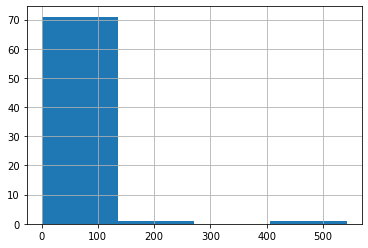

In [32]:
import matplotlib.pyplot as plt

laval_venues['total likes'].hist(bins=4)
plt.show()

<h3>Identifing the bin value to use</h3>

In [33]:
print(np.percentile(laval_venues['total likes'], 25))
print(np.percentile(laval_venues['total likes'], 50))
print(np.percentile(laval_venues['total likes'], 75))

8.0
14.0
28.0


<h3>Now is the time to assign a value to these identifiers.</h3>

In [34]:

poor = laval_venues['total likes']<=8.75
below_avg = laval_venues[(laval_venues['total likes']>8.75) & (laval_venues['total likes']<=14.5)]
abv_avg = laval_venues[(laval_venues['total likes']>14.5) & (laval_venues['total likes']<=26.5)]
great = laval_venues['total likes']>26.5

In [35]:
# let's set up a function that will re-categorize our commercial places based on likes

def conditions(s):
    if s['total likes']<=8.75:
        return 'poor'
    if s['total likes']<=14.5:
        return 'below avg'
    if s['total likes']<=26.5:
        return 'avg avg'
    if s['total likes']>26.5:
        return 'great'

laval_venues['total likes_cat']=laval_venues.apply(conditions, axis=1)

In [36]:
laval_venues

,name,id,categories,lat,lng,total likes,total likes_cat
0,L'Oeufrier,4dd687eb1f6ee146830b620f,Breakfast Spot,45.596952,-73.722302,12,below avg
1,grange urbaine,53c54e2b498eaaf9ec4bd1b2,Restaurant,45.601397,-73.726816,9,below avg
2,Bulk Barn,528be7fd498efcbda5504fef,Food & Drink Shop,45.609808,-73.735094,7,poor
4,iSaute Centre de Trampoline,5284259911d2076c8f1761d9,Theme Park,45.588187,-73.767266,25,avg avg
6,McDonald's,4cad0d3bd971b1f76fea35e1,Fast Food Restaurant,45.611054,-73.736770,10,below avg
7,Tamashi,4bc26b642a89ef3bfbd4f388,Asian Restaurant,45.581021,-73.704181,42,great
10,Michaels,5035132ae4b0aa0a3c9be2cb,Arts & Crafts Store,45.607688,-73.696526,15,avg avg
12,Hilton,4bce294f68f976b07d906583,Hotel,45.570132,-73.743107,29,great
13,Station des Sports,51bcd865498e1ea22433e9a8,Sports Bar,45.589910,-73.741611,24,avg avg
14,Fuzion Zen,4b1ae47cf964a52014f423e3,Asian Restaurant,45.617399,-73.782120,7,poor


<h3>Categorisation</h3>

Here is a pleasant part where I categorise my results.

In [37]:
convenience = ['Grocery Store', 'Food Service', 'Rental Service', 'Soccer Field', 'Theme Park']
other = ['Cosmetics Shop', 'Museum', 'Discount Store', 'Hotel', 'Furniture / Home Store', 'Bookstore', 'Clothing Store', 'Board Shop', 'Kitchen Supply Store', 'BBQ Joint', 'Department Store',
        'Warehouse Store', 'Camera Store', 'Board Shop', 'Arts & Crafts Store', 'Hardware Store']
fast_food_restaurant = ['Pizza Place', 'Fast Food Restaurant' ]
competition =  ['Coffee Shop' , 'Diner', 'Sandwich Place', 'Chocolate Shop', 'Bakery', 'Coffee Shop', 'Ice Cream Shop']
worldwide_restaurant = ['Thai Restaurant', 'Chinese Restaurant', 'Tex-Mex Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'New American Restaurant', 'Brazilian Restaurant',
                        'Sushi Restaurant', 'Asian Restaurant', 'French Restaurant', 'Greek Restaurant']
other_restaurant = ['Restaurant', 'Steakhouse', 'Breakfast Spot' ]
bars = ['Bar', 'Tea Room', 'Sports Bar', 'Lounge', 'Dive Bar']


def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in convenience:
        return 'convenience'
    if s['categories'] in fast_food_restaurant:
        return 'fast_food_restaurant'
    if s['categories'] in worldwide_restaurant:
        return 'worldwide_restaurant'
    if s['categories'] in other_restaurant:
        return 'other_restaurant'
    if s['categories'] in competition:
        return 'competition'

laval_venues['categories_new']=laval_venues.apply(conditions2, axis=1)

<h3>Now let's create variables for our total likes and categories so we can cluster</h3>

In [38]:
# one first code
laval_first = pd.get_dummies(laval_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
laval_first['Name'] = laval_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [laval_first.columns[-1]] + list(laval_first.columns[:-1])
laval_first = laval_first[fixed_columns]

laval_first.head()

,Name,bars,competition,convenience,fast_food_restaurant,other,other_restaurant,worldwide_restaurant,avg avg,below avg,great,poor
0,L'Oeufrier,0,0,0,0,0,1,0,0,1,0,0
1,grange urbaine,0,0,0,0,0,1,0,0,1,0,0
2,Bulk Barn,0,0,0,0,0,0,0,0,0,0,1
4,iSaute Centre de Trampoline,0,0,1,0,0,0,0,1,0,0,0
6,McDonald's,0,0,0,1,0,0,0,0,1,0,0


<h3>Clustering</h3>
    
Now let's run our k-means clustering algorythm to get our labels

In [39]:
cluster_df = laval_first.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
laval_kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
laval_kmeans.labels_[0:10]

array([0, 0, 1, 2, 0, 3, 2, 3, 2, 1], dtype=int32)

In [40]:
laval_venues['label'] = laval_kmeans.labels_
laval_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,L'Oeufrier,4dd687eb1f6ee146830b620f,Breakfast Spot,45.596952,-73.722302,12,below avg,other_restaurant,0
1,grange urbaine,53c54e2b498eaaf9ec4bd1b2,Restaurant,45.601397,-73.726816,9,below avg,other_restaurant,0
2,Bulk Barn,528be7fd498efcbda5504fef,Food & Drink Shop,45.609808,-73.735094,7,poor,None,1
4,iSaute Centre de Trampoline,5284259911d2076c8f1761d9,Theme Park,45.588187,-73.767266,25,avg avg,convenience,2
6,McDonald's,4cad0d3bd971b1f76fea35e1,Fast Food Restaurant,45.611054,-73.736770,10,below avg,fast_food_restaurant,0


<h3>Expose what we are looking for on a map</h3>

In [41]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(laval_venues['lat'], laval_venues['lng'], laval_venues['name'], laval_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

It's getting perfect. Now, we take a look on below avg results

In [42]:
laval_venues.loc[laval_venues['label']==0]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,L'Oeufrier,4dd687eb1f6ee146830b620f,Breakfast Spot,45.596952,-73.722302,12,below avg,other_restaurant,0
1,grange urbaine,53c54e2b498eaaf9ec4bd1b2,Restaurant,45.601397,-73.726816,9,below avg,other_restaurant,0
6,McDonald's,4cad0d3bd971b1f76fea35e1,Fast Food Restaurant,45.611054,-73.736770,10,below avg,fast_food_restaurant,0
16,Makoto Sushi,4bafdb64f964a52088263ce3,Sushi Restaurant,45.576694,-73.712704,12,below avg,worldwide_restaurant,0
19,Le Milsa,4bd76b0735aad13a7add8ef3,Brazilian Restaurant,45.576349,-73.713537,11,below avg,worldwide_restaurant,0
35,Tim Hortons,4e2850a5b0fba988bb6a6f80,Coffee Shop,45.584285,-73.750204,10,below avg,competition,0
42,Billard des Pros,4c9f77ff8afca093084d0a16,Bar,45.625667,-73.751151,9,below avg,bars,0
45,Oberson,4b31814af964a5201a0825e3,Board Shop,45.578036,-73.700111,10,below avg,other,0
52,Gosselin,5380e525498e15919e8cd9a5,Camera Store,45.564296,-73.730453,14,below avg,other,0
57,Menus Plaisirs,4c8a84289ef0224b529d5b7b,French Restaurant,45.612283,-73.788564,14,below avg,worldwide_restaurant,0


<h2>Avg Results<h2>

In [43]:
laval_venues.loc[laval_venues['label']==1]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
2,Bulk Barn,528be7fd498efcbda5504fef,Food & Drink Shop,45.609808,-73.735094,7,poor,None,1
14,Fuzion Zen,4b1ae47cf964a52014f423e3,Asian Restaurant,45.617399,-73.782120,7,poor,worldwide_restaurant,1
17,Chez Cora,4bf80a315ec320a1eef787d3,Breakfast Spot,45.608587,-73.734476,8,poor,other_restaurant,1
29,Industria Pizzeria + Bar,5aa472d666f3cd532b936600,Restaurant,45.570206,-73.751962,6,poor,other_restaurant,1
32,Au Pain Doré,4d29fb9ac406721e8bd77fb6,French Restaurant,45.566271,-73.727794,7,poor,worldwide_restaurant,1
37,Godiva Chocolatier,4ed7d8506aa34644cf4fc4bd,Chocolate Shop,45.570801,-73.751406,8,poor,competition,1
38,Avril Supermarché Santé,5b2399419b0473002bf8b062,Health Food Store,45.563352,-73.733239,8,poor,None,1
50,Parc Curé-Coursol,4c24d74bf3859c74370a6588,Tennis Court,45.583636,-73.714494,7,poor,None,1
51,Artemano Laval,4cc75c5ede08199c4c4bec5e,Furniture / Home Store,45.567765,-73.736167,7,poor,other,1
54,Nespresso,5842f173158bbb646707ad44,Coffee Shop,45.569564,-73.750325,7,poor,competition,1


<h3>Highly rated (now it's interesting)</h3>

In [44]:
laval_venues.loc[laval_venues['label']==2]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
4,iSaute Centre de Trampoline,5284259911d2076c8f1761d9,Theme Park,45.588187,-73.767266,25,avg avg,convenience,2
10,Michaels,5035132ae4b0aa0a3c9be2cb,Arts & Crafts Store,45.607688,-73.696526,15,avg avg,other,2
13,Station des Sports,51bcd865498e1ea22433e9a8,Sports Bar,45.589910,-73.741611,24,avg avg,bars,2
20,Canadian Tire,4b64817df964a52012b92ae3,Hardware Store,45.609491,-73.696041,24,avg avg,other,2
31,Le Tire-Bouchon,4adb6650f964a520fe2621e3,French Restaurant,45.563045,-73.744503,17,avg avg,worldwide_restaurant,2
33,Centre sportif Bois-de-Boulogne,4af099b9f964a5208cdd21e3,Soccer Field,45.574016,-73.704460,16,avg avg,convenience,2
40,Crémerie Pineault,4bf47cc898ac0f473f1764a8,Ice Cream Shop,45.608064,-73.674642,24,avg avg,competition,2
47,Le Boating Club,53e6b7c7498e08a1daea6ad3,Restaurant,45.611615,-73.792220,24,avg avg,other_restaurant,2
53,DAVIDsTEA,4bb3ba6feb3e9521ae8dcb0a,Tea Room,45.571143,-73.754289,25,avg avg,bars,2
59,Bottega,4bc7c051af07a59337e17f2d,Italian Restaurant,45.564671,-73.734390,26,avg avg,worldwide_restaurant,2


<h3>Results</h3>

We obtained a top 20 of addresses of the most appreciated addresses in Laval in categories of places corresponding to the searched field. 

To support our results, we complete them with the addresses having obtained an average score and a score below the average, for the same number.

<h3>Discussion</h3>

Obviously, there is a lot of attraction around Laval's busiest shopping center and movie theater and that is reflected a lot around its two locations which are also nearby.

<h3>Conclusion</h3>

I remind you: Laval is (relatively) a small city and that limited the range of results. Obviously, the excitement is concentrated on a region which is still quite specific, which facilitated reading and influenced the results in a fairly clear direction, thus limiting the possibility of inaccuracy.
However, even if I had my doubts, the exercise achieved its ultimate goal, which is to enlighten a restaurant contractor on the road on the places to frequent to enjoy the best possible visibility.